In [ ]:
import pandas as pd

from utils.extract import amp_phase_from_csi
from utils.load import load_csi_data
from utils.normalize import amplitude_normalization
from utils.noise_filtering import dwt_denoise_matrix
from utils.crop import crop_time
from utils.csi_amp_visualize import plot_csi_amp_heatmap

In [84]:
def preprocess_csi_data(excel_file):
    # CSI 데이터 로드
    data = load_csi_data(excel_file)
    
    # 진폭 및 위상 추출
    amp, _ = amp_phase_from_csi(data)

    # 시간축 크롭
    cropped_amp = crop_time(amp, window_size=500)
    
    # 진폭 정규화
    normalized_amp = amplitude_normalization(cropped_amp)

    # 노이즈 제거
    noise_filtered_amp = dwt_denoise_matrix(normalized_amp)
    
    return noise_filtered_amp

In [79]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
# utils.extract와 utils.load는 외부 모듈이므로 그대로 가정
from utils.extract import amp_phase_from_csi
from utils.load import load_csi_data # Excel 경로도 처리한다고 가정

# Matplotlib 설정을 'Agg'에서 기본 GUI 백엔드로 되돌립니다.
# 함수가 Figure 객체를 반환하므로 노트북/스크립트 환경에서 표시될 수 있습니다.
# import matplotlib
# matplotlib.use("Agg") # 주석 처리/제거

def load_raw_amp(file_path: Path) -> np.ndarray:
    """
    원본 파일 경로 (CSV 또는 Excel) -> (amp, phase) 중 amp만 사용.
    amp_phase_from_csi의 입력 형식에 맞추어 numeric matrix를 전달합니다.
    이후 (T,F) 중 T를 [0:500] 구간으로 슬라이싱합니다.
    """
    # Excel 경로 처리 가정을 위해 함수명은 변경하지 않고 인자명만 csv_path에서 file_path로 변경
    raw = load_csi_data(file_path)
    amp, _ = amp_phase_from_csi(raw)
    amp = np.asarray(amp)
    if amp.ndim != 2:
        raise ValueError(f"Amplitude must be 2D (T,F). Got shape {amp.shape} from {file_path}")

    # 첫 500 타임스텝만 사용 (T가 500보다 작아도 에러 없이 처리)
    T = amp.shape[0]
    end = min(500, T)
    amp = amp[:end, :]

    return amp.astype(np.float32, copy=False) # dtype 통일

def compute_shared_scale(a: np.ndarray, b: np.ndarray, pct_lo: float = 1.0, pct_hi: float = 99.0) -> Tuple[float, float]:
    """두 이미지에 공통 vmin/vmax를 주기 위해 퍼센타일 기반 스케일 계산."""
    both = np.concatenate([a.reshape(-1), b.reshape(-1)])
    # NaN 값은 무시하고 백분위 계산
    vmin = float(np.nanpercentile(both, pct_lo))
    vmax = float(np.nanpercentile(both, pct_hi))
    if vmin == vmax:
        vmax = vmin + 1e-6
    return vmin, vmax

def visualize_compare_csi(
    raw_file_path: Path,
    amp_proc: np.ndarray,
    title_raw: str = "RAW Amplitude",
    title_proc: str = "PREPROCESSED Amplitude",
    shared_scale: bool = True,
    cmap: str = "viridis",
    figsize: Tuple[int,int] = (14, 5)
) -> plt.Figure:
    """
    원본 CSI 파일(Excel/CSV)에서 추출한 $\\text{amp}$와 전처리된 $\\text{amp}$를 비교하여 시각화합니다.

    Args:
        raw_file_path: 원본 데이터 파일 경로 (Path, CSV 또는 Excel).
        amp_proc: 전처리된 CSI 진폭 데이터 ($\mathbf{numpy.ndarray}$, (T, F) 형태).
        title_raw: 원본 데이터 히트맵 제목.
        title_proc: 전처리 데이터 히트맵 제목.
        shared_scale: 두 이미지에 같은 컬러 스케일 ($\mathbf{vmin/vmax}$)을 적용할지 여부.
        cmap: Matplotlib 컬러맵.
        figsize: Matplotlib Figure 크기.

    Returns:
        두 히트맵이 포함된 Matplotlib Figure 객체.
    """
    # 1. 원본 데이터 로드 및 슬라이싱 (T, F)
    try:
        amp_raw = load_raw_amp(raw_file_path)
    except Exception as e:
        raise ValueError(f"Error loading raw data from {raw_file_path}: {e}")

    # 2. 전처리 데이터 형태 확인 (T, F)
    if amp_proc.ndim == 3 and amp_proc.shape[0] == 1:
        amp_proc = amp_proc[0]
    if amp_proc.ndim != 2:
        raise ValueError(f"Preprocessed array must be 2D (T,F) or (1,T,F). Got {amp_proc.shape}")
    
    # 3. 공통 스케일 계산
    if shared_scale:
        vmin, vmax = compute_shared_scale(amp_raw, amp_proc, 1.0, 99.0)
    else:
        vmin = vmax = None

    # 4. 시각화
    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)

    # 원본 데이터 시각화
    im0 = axes[0].imshow(amp_raw.T, aspect="auto", origin="lower",
                         cmap=cmap, vmin=vmin, vmax=vmin if not shared_scale else vmax)
    axes[0].set_title(f"{title_raw}\nshape={amp_raw.shape}")
    axes[0].set_xlabel("Time index")
    axes[0].set_ylabel("Subcarrier")

    # 전처리 데이터 시각화
    im1 = axes[1].imshow(amp_proc.T, aspect="auto", origin="lower",
                         cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(f"{title_proc}\nshape={amp_proc.shape}")
    axes[1].set_xlabel("Time index")
    axes[1].set_ylabel("Subcarrier")

    # 컬러바 추가
    # shared_scale이 False이면 im0/im1 각각에 맞춰 다른 컬러바를 그려야 하지만,
    # 요구사항에 따라 간단히 단일 컬러바(im1 기준)만 추가합니다.
    # 두 개의 컬러바를 그리려면 별도의 로직이 필요합니다.
    cbar_target = im1 if shared_scale else im0
    cbar = fig.colorbar(cbar_target, ax=axes.ravel().tolist(), shrink=0.9)
    cbar.set_label("Amplitude (arbitrary)")

    return fig

<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ssalt\AppData\Local\Temp\ipykernel_29572\3008976575.py:59: SyntaxWarning: invalid escape sequence '\m'
  amp_proc: 전처리된 CSI 진폭 데이터 ($\mathbf{numpy.ndarray}$, (T, F) 형태).


In [86]:
path = 'C:\\Users\\ssalt\\SOOM\\SOOM-dataset\\dataset\\BPM-10\\BPM10-1.csv'
preprocessed_data = preprocess_csi_data(path)

C:\Users\ssalt\AppData\Local\Temp\ipykernel_29572\1335575811.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


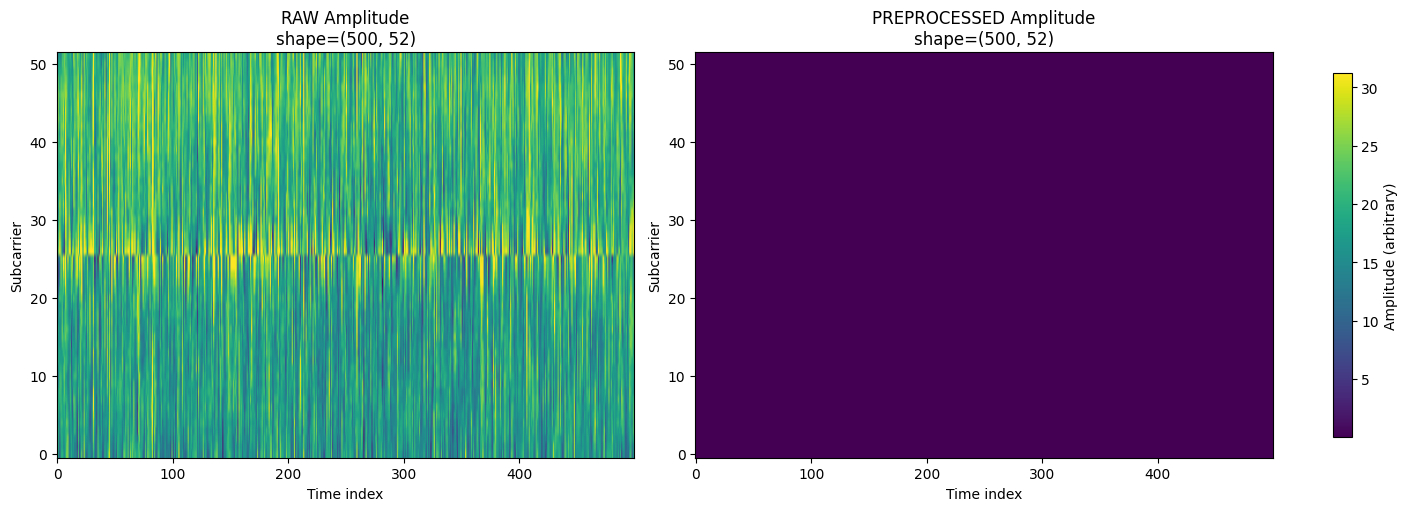

In [81]:
fig = visualize_compare_csi(path, preprocessed_data)
fig.show()

In [82]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def visualize_preprocessed_csi(
    amp_proc: np.ndarray,
    title: str = "Preprocessed CSI Amplitude (T, F)",
    cmap: str = "viridis",
    figsize: Tuple[int,int] = (7, 5)
) -> plt.Figure:
    """
    전처리된 CSI 진폭 데이터(numpy.ndarray)를 히트맵으로 시각화하고 Figure 객체를 반환합니다.

    Args:
        amp_proc: 전처리된 CSI 진폭 데이터 (T, F) 또는 (1, T, F) 형태.
        title: 히트맵의 제목.
        cmap: Matplotlib 컬러맵.
        figsize: Matplotlib Figure 크기.

    Returns:
        히트맵이 포함된 Matplotlib Figure 객체.
    """
    # (1, T, F) 형태를 (T, F)로 squeeze
    if amp_proc.ndim == 3 and amp_proc.shape[0] == 1:
        data = amp_proc[0]
    elif amp_proc.ndim == 2:
        data = amp_proc
    else:
        raise ValueError(f"Input array must be 2D (T,F) or 3D (1,T,F). Got {amp_proc.shape}")
        
    data = data.astype(np.float32, copy=False)

    # 데이터의 vmin/vmax를 1%~99% percentile로 설정 (이상치 영향 최소화)
    v_lo = float(np.nanpercentile(data, 1.0))
    v_hi = float(np.nanpercentile(data, 99.0))
    if v_lo == v_hi:
        v_hi = v_lo + 1e-6 # 예외 처리

    # Figure 생성
    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    # 히트맵 그리기
    # data.T: T(Time)가 X축, F(Subcarrier)가 Y축이 되도록 전치 (Origin CSI 그래프 표준)
    im = ax.imshow(data.T, aspect="auto", origin="lower",
                   cmap=cmap, vmin=v_lo, vmax=v_hi)

    # 제목 및 라벨 설정
    ax.set_title(f"{title}\nShape={data.shape}")
    ax.set_xlabel("Time index (T)")
    ax.set_ylabel("Subcarrier index (F)")

    # 컬러바 추가
    cbar = fig.colorbar(im, ax=ax, shrink=0.9)
    cbar.set_label("Amplitude (arbitrary)")

    return fig

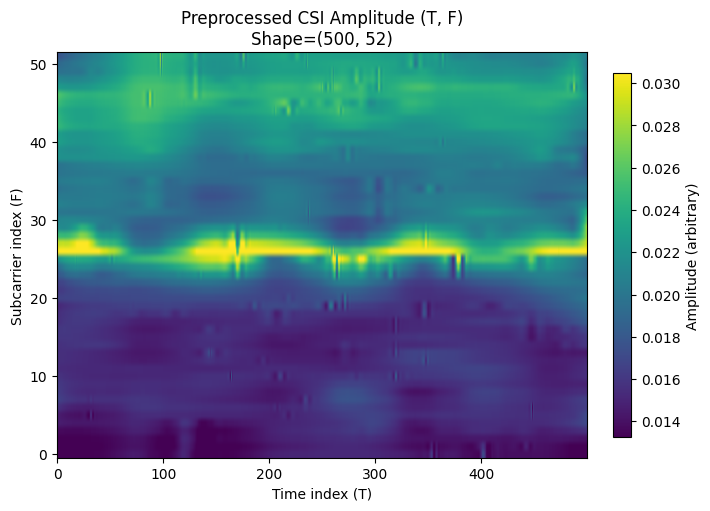

In [87]:
fig = visualize_preprocessed_csi(preprocessed_data)

In [32]:
import numpy as np
from sklearn.decomposition import PCA
from typing import Optional

def pca_52_subcarriers(
    data: np.ndarray,
    n_components: int = 10
) -> np.ndarray:
    """
    52개의 서브캐리어(특징)에 대해 PCA를 적용하여 차원을 축소합니다.

    Args:
        data: 입력 CSI 데이터. 
              (T, F=52) 형태 또는 (B, T, F=52) 형태여야 합니다.
        n_components: 축소할 주성분(서브캐리어)의 개수. (1 <= n_components <= 52)

    Returns:
        PCA가 적용된 데이터.
        입력 형태가 (T, F)이면 (T, n_components)로,
        (B, T, F)이면 (B, T, n_components)로 반환됩니다.
    """
    if data.shape[-1] != 52:
        raise ValueError(f"마지막 차원(서브캐리어 개수)은 52여야 합니다. 현재: {data.shape[-1]}")
    if not 1 <= n_components <= 52:
        raise ValueError(f"n_components는 1에서 52 사이여야 합니다. 현재: {n_components}")

    original_shape = data.shape
    
    # 1. 3D (B, T, F)를 2D (B*T, F)로 변환
    if data.ndim == 3:
        B, T, F = original_shape
        # (B, T, F) -> (B*T, F)
        data_2d = data.reshape(-1, F)
    elif data.ndim == 2:
        T, F = original_shape
        # (T, F)
        data_2d = data
        B = 1 # 배치 차원이 없음을 표시
    else:
        raise ValueError(f"입력 데이터는 2차원 (T, F) 또는 3차원 (B, T, F) 형태여야 합니다. Got shape {original_shape}")

    # 2. PCA 적용
    # PCA는 내부적으로 데이터를 평균 0, 표준편차 1로 스케일링하지 않으므로,
    # 필요하다면 이전에 표준화(Standardization)를 수행해야 합니다.
    # 여기서는 서브캐리어 간의 분산 차이가 중요하다고 가정하고 스케일링 없이 진행합니다.
    pca = PCA(n_components=n_components)
    
    # data_2d는 (샘플 수, 특징 수) 형태
    data_pca = pca.fit_transform(data_2d) # (B*T, n_components) 또는 (T, n_components)

    # 3. 결과 형태 복원
    if data.ndim == 3:
        # (B*T, n_components) -> (B, T, n_components)
        result_shape = (B, T, n_components)
        return data_pca.reshape(result_shape)
    else: # data.ndim == 2
        # (T, n_components)
        return data_pca

In [66]:
def preprocess_csi_data(excel_file):
    # CSI 데이터 로드
    data = load_csi_data(excel_file)
    
    # 진폭 및 위상 추출
    amp, _ = amp_phase_from_csi(data)

    # 시간축 크롭
    cropped_amp = crop_time(amp, window_size=500)
    
    # 진폭 정규화
    normalized_amp = amplitude_normalization(cropped_amp)

    # 노이즈 제거
    noise_filtered_amp = dwt_denoise_matrix(normalized_amp)

    # pca
    pca_amp = pca_52_subcarriers(noise_filtered_amp, 1)
    
    return pca_amp

In [67]:
preprocessed_data = preprocess_csi_data(path)

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def visualize_pca_1d_result(
    pca_result_1d: np.ndarray,
    title: str = "PCA 1st Principal Component Time Series",
    figsize: Tuple[int,int] = (10, 4)
) -> plt.Figure:
    """
    이미 PCA로 (T, 1) 또는 (T,) 형태로 축소된 데이터를 시계열로 시각화합니다.

    Args:
        pca_result_1d: PCA로 축소된 1차원 데이터. 
                       (T, 1) 또는 (T,) 형태여야 합니다.
        title: 그래프의 제목.
        figsize: Matplotlib Figure 크기.

    Returns:
        시계열 그래프가 포함된 Matplotlib Figure 객체.
    """
    # 데이터 형태 정제: (T, 1) 형태를 (T,) 형태로 변환
    if pca_result_1d.ndim == 2:
        if pca_result_1d.shape[1] == 1:
            data_1d = pca_result_1d.flatten()
        else:
            raise ValueError(f"입력 데이터는 (T, 1) 또는 (T,) 형태여야 합니다. Got {pca_result_1d.shape}")
    elif pca_result_1d.ndim == 1:
        data_1d = pca_result_1d
    else:
        raise ValueError(f"입력 데이터는 1차원(T,) 또는 2차원(T, 1) 형태여야 합니다. Got {pca_result_1d.shape}")
        
    T = data_1d.shape[0]
    time_indices = np.arange(T)

    # 1. 시계열 그래프 생성
    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    ax.plot(time_indices, data_1d, label="PC 1", color='b', linewidth=1)

    # 2. 제목 및 라벨 설정
    ax.set_title(f"{title}\nLength: {T}")
    ax.set_xlabel("Time index (T)")
    ax.set_ylabel("Amplitude of Principal Component")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    # 3. Figure 객체 반환
    return fig

In [69]:
preprocessed_data.shape

(500, 1)

C:\Users\ssalt\AppData\Local\Temp\ipykernel_29572\941079565.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


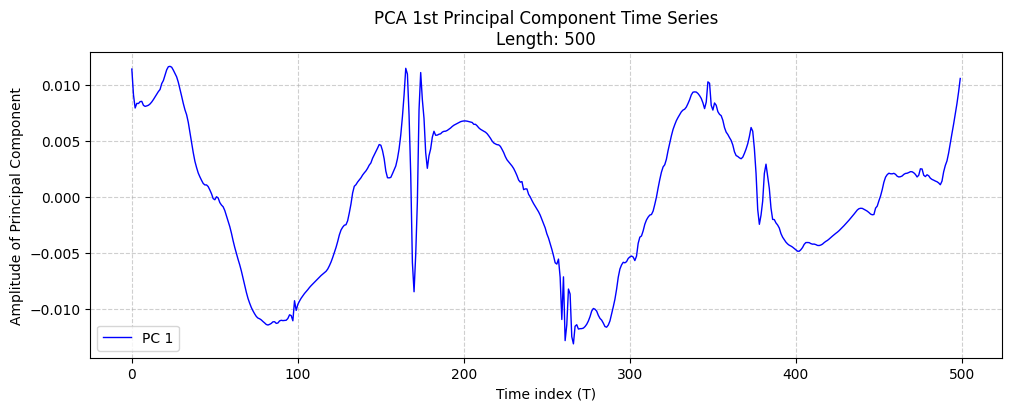

In [70]:
fig = visualize_pca_1d_result(preprocessed_data)
fig.show()

In [71]:
import numpy as np
from typing import Tuple

def fft_lowpass_filter(
    data_1d: np.ndarray,
    cutoff_freq_ratio: float = 0.05,
    sampling_rate: Optional[int] = None
) -> np.ndarray:
    """
    PCA로 축소된 1차원 시계열 데이터에 FFT 기반 저역 통과 필터를 적용합니다.

    Args:
        data_1d: PCA로 축소된 1차원 데이터 (T,) 형태.
        cutoff_freq_ratio: 필터링할 주파수의 비율. 
                           (0 < ratio < 0.5, N/2 지점에서 N * ratio 지점까지의 성분을 남김)
                           예: 0.05는 전체 주파수 범위의 5%만 남김.
        sampling_rate: 데이터의 실제 샘플링 속도 (Hz). 이 값이 제공되면 cutoff_freq_ratio 대신
                       실제 주파수(Hz)를 기준으로 필터링할 수 있지만, 여기서는 비율을 사용합니다.
    
    Returns:
        저역 통과 필터가 적용된 1차원 데이터 (T,) 형태.
    """
    # 데이터 형태 확인 및 (T,)로 변환
    if data_1d.ndim == 2 and data_1d.shape[1] == 1:
        data_1d = data_1d.flatten()
    elif data_1d.ndim != 1:
        raise ValueError("입력 데이터는 1차원(T,) 또는 2차원(T, 1) 형태여야 합니다.")
        
    T = data_1d.shape[0]

    # 1. FFT 수행
    # data_fft: 복소수 배열 (DC 성분부터 Nyquist 주파수까지 포함)
    data_fft = np.fft.fft(data_1d)
    
    # 2. 필터 마스크 생성 (저역 통과 필터)
    # FFT 결과의 인덱스는 0부터 T-1까지. 0은 DC, T/2 근처는 Nyquist 주파수.
    # 대칭성을 고려하여 T/2 지점에서 필터링해야 함.
    cutoff_index = int(T * cutoff_freq_ratio)
    
    # 마스크 생성: 저주파 성분(0 ~ cutoff_index)만 남기고 나머지는 0으로 설정
    mask = np.zeros(T, dtype=bool)
    
    # DC 및 양의 주파수 성분 (0에서 cutoff_index - 1)
    mask[:cutoff_index] = True
    
    # 음의 주파수 성분 (대칭되는 부분)
    # T - (cutoff_index - 1) 부터 T-1 까지
    mask[T - cutoff_index:] = True 
    
    # 3. 필터 적용
    data_fft_filtered = data_fft * mask
    
    # 4. iFFT (역 고속 푸리에 변환) 수행
    data_filtered = np.fft.ifft(data_fft_filtered)
    
    # 실수 성분만 추출 (필터링된 결과는 실수여야 함)
    return np.real(data_filtered)

In [72]:
fft_filtered = fft_lowpass_filter(preprocessed_data)

C:\Users\ssalt\AppData\Local\Temp\ipykernel_29572\2570208310.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


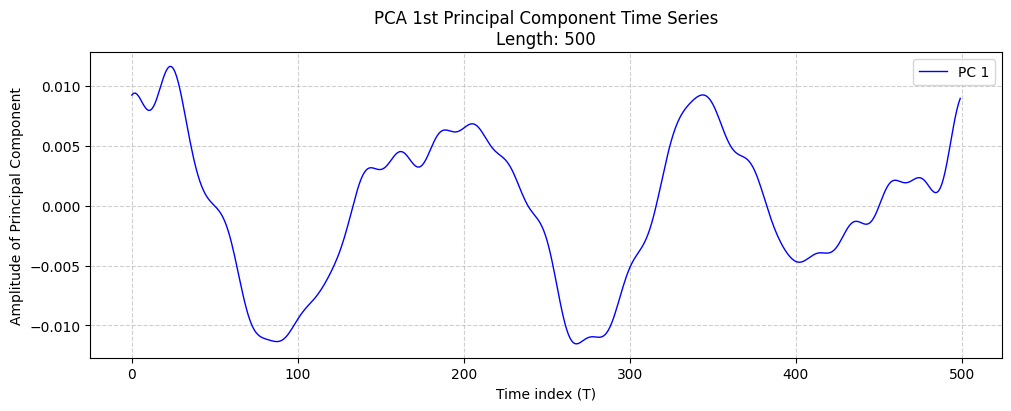

In [ ]:
fig = visualize_pca_1d_result(fft_filtered)
fig.show()

In [95]:
import pandas as pd

from utils.extract import amp_phase_from_csi
from utils.load import load_csi_data
from utils.normalize import amplitude_normalization
from utils.noise_filtering import dwt_denoise_matrix
from utils.crop import crop_time
from utils.csi_amp_visualize import plot_csi_amp_heatmap
from utils.pca import pca_52_subcarriers
from utils.fft_filter import fft_lowpass_filter
# from utils.kalman_filter import kalman_denoise_matrix


def preprocess_csi_data(excel_file):
    # CSI 데이터 로드
    data = load_csi_data(excel_file)
    
    # 진폭 및 위상 추출
    amp, _ = amp_phase_from_csi(data, "CSI_DATA")

    # 시간축 크롭
    # cropped_amp = crop_time(amp, window_size=500)
    
    # 진폭 정규화
    normalized_amp = amplitude_normalization(amp)

    # 노이즈 제거
    noise_filtered_amp = dwt_denoise_matrix(normalized_amp)
    # noise_filtered_amp = kalman_denoise_matrix(normalized_amp)

    # pca
    pca_amp = pca_52_subcarriers(noise_filtered_amp, 1)

    # fft lowpass filter
    fft_filtered = fft_lowpass_filter(pca_amp)

    return fft_filtered

In [96]:
data_path = "C:\\Users\\ssalt\\SOOM\\SOOM-AI\\Breathing - 12 BPM - CSI.csv"
data = preprocess_csi_data(data_path)
fig = visualize_pca_1d_result(data)
fig.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<UNKNOWN>, line 1)